In [112]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy.optimize
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Will solve the following equations in one dimension

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

Following then the continuity equation in 1D

$$
\begin{align}
\frac{\partial \rho}{\partial t} &= -\frac{\partial \rho u}{\partial x} \\
\end{align}
$$

But in order to solve this we must first numerically solve $\frac{\partial \rho u}{\partial x}$

$$
\begin{align}
\frac{\partial \rho u}{\partial x} &= \left(u \frac{\partial \rho}{\partial x} + \rho \frac{\partial u}{\partial x}\right)
\end{align}
$$
And the LHS becomes
$$
\begin{align}
\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1} - \rho^n}{\Delta t}
\end{align}
$$
Then 
$$
\rho^{n+1} = \rho^n - \Delta t \left(u^n \left[\frac{\partial \rho}{\partial x}\right]^n + \rho^n \left[\frac{\partial u}{\partial x}\right]^n\right)
$$
Where the brackets represent the derivative scheme, which is going to be dependent on the flow direction

Now for the momentum equation

$$
\begin{align}
\frac{\partial (\rho \mathbf{u})}{\partial t} + \nabla \cdot (\rho \mathbf{u} \otimes \mathbf{u}) = -\nabla (P_g)
\end{align}
$$
In one dimension we have then
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \frac{\partial \left(\rho u^2\right)}{\partial x} = -\frac{\partial}{\partial x} (P_g)
\end{align}
$$

We have already done the first term, so the second term with the help of product rule becomes
$$
\begin{align}
\frac{\partial \left(\rho u^2\right)}{\partial x} &= \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}
\end{align}
$$
This turns the momentum equation into
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}= -\frac{\partial}{\partial x} (P_g)
\end{align}
$$
Discretized
$$
\begin{align}
\left[\frac{\partial (\rho u)}{\partial t}\right]^n =- \left[\rho u\right]^n \left[\frac{\partial u}{\partial x}\right]^n - u^n\left[\frac{\partial (\rho u)}{\partial x}\right]^n-\left[\frac{\partial}{\partial x} (P_g)\right]^n
\end{align}
$$
But this is also aprroximated to
$$
\left[\frac{\partial \rho u}{\partial t}\right]^n \approx \frac{\left[\rho u\right]^{n+1} - \left[\rho u\right]^n}{\Delta t}
$$
Meaning we get
$$
u^{n+1} = \frac{\left[\rho u\right]^n + \left[\frac{\partial \rho u}{\partial t}\right]^n \Delta t}{\rho^{n+1}}\
$$
Where again we must be carefull of which scheme to use on $\frac{\partial \rho u}{\partial t}$

Lastly the energy equation

$$
\frac{\partial e}{\partial t} = - \frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x}
$$
RHS turns into
$$
-\frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x} = -(e + P) \frac{\partial u}{\partial x} - u\frac{\partial e}{\partial x}
$$
So energy
$$
e^{n+1} = e^n + \left[\frac{\partial e}{\partial t}\right]^n \Delta t
$$

Only LAX method in Julia, start with implenting just Python.

Hint from tor. Make Lax in SOD Laxer

1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt

In [48]:
def e_step(xx, uu, e, Pg, dt):
    """
    Returns the e^{n+1} in the energy equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    e   : `array`
        Energy function that depends on xx
    Pg  : `array`
        Pressure function that depend on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for e^{n+1}
    """
    # Implementing the upwind and downwind in one line
    term1 = nm.deriv_upw(xx, e)
    term2 = nm.deriv_dnw(xx, e)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu<0)]
    else:
        term2 = np.zeros_like(term1)
        
    ddx_e = term1 + term2
    
    # Calculate the derivative
    ddt_e = -(e + Pg)*nm.deriv_cent(xx, uu) - uu*ddx_e
    ennt = e + ddt_e*dt
    return ennt
    
def rho_step(xx, uu, rho, dt):
    """
    Returns the rho^{n+1} in the momentum equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density function that depends on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    term1 = nm.deriv_upw(xx, rho) #[np.where(uu>=0)]
    term2 = nm.deriv_dnw(xx, rho) #[np.where(uu<0)]
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rho = term1 + term2
    ddx_u = nm.deriv_cent(xx, uu)
    rho_nnt = rho - dt*(uu*ddx_rho + rho*ddx_u)
    # Avijeet did something smart
    return rho_nnt
    
def lax_method(xx, hh, dt, dx, bnd_limits=[0, 1], bnd_type="wrap"):
    N = len(xx)
    ans = np.zeros(N)
    term1 = np.roll(hh, -1) + np.roll(hh, 1)
    term2 = np.roll(hh, -1) - np.roll(hh, 1)
    frac = (hh*dt) / (2*dx)
    tmmp = 0.5*term1 - frac*term2
    # For upwind and centre
    if bnd_limits[1] > 0:
        ans = np.pad(tmmp[bnd_limits[0]: -bnd_limits[1]], bnd_limits, bnd_type)
    # For downwind
    else:
        ans = np.pad(tmmp[bnd_limits[0]:], bnd_limits, bnd_type)
    return ans


def ddt_rhou(xx, uu, P, rhou):
    """
    Returns the rhs for the ddt_rhou equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    P : `array`
        Pressure function that depends on xx
    rhou : `array`
        Momentum function that depends on xx

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    ddx_u = nm.deriv_cent(xx, uu)
    term1 = nm.deriv_upw(xx, rhou)
    term2 = nm.deriv_dnw(xx, rhou)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rhou = term1 + term2
    ddx_P = nm.deriv_cent(xx, P)
    
    ans = -rhou*ddx_u - uu*ddx_rhou - ddx_P
    return ans

def u_step(xx, uu, rho, P, dt):
    """
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.

    Returns
    -------
    """
    rhou = rho*uu
    dd_rhou = ddt_rhou(xx, uu, P, rhou)
    rho_nnt = rho_step(xx, uu, rho, dt)
    
    unnt = (rhou + dd_rhou*dt)/rho_nnt 
    return unnt
    
def bifrost_6th(xx, hh):
    c = 3/640
    b = 1/24 - 3*c
    a = 1 - 3*b + 5*c

    dx = np.gradient(xx)

    term1 = a/dx*(hh - np.roll(hh, -1))
    term2 = b/dx*(np.roll(hh, 1) - np.roll(hh, -2))
    term3 = c/dx*(np.roll(hh, 2) - np.roll(hh, -3))
    
    rhs = term1 + term2 + term3
    return rhs
    
def flux_limiter(xx, hh, lamba):
    """Lax simple scheme"""
    pass

def P(e, rho, γ=5/3):
    """
    Calculates the Pressure

    Parameters:
    -----------
    e
    """
    prod = e#/rho
    ans = (γ - 1)*prod
    return ans

def initialise(nx, ny, nz, nt, P0, rho0, γ=5/3):

    if (ny == 1) and (nz == 1):
        N = nx
    else:
        N = (nx, ny, nz)
    Pg = np.zeros((N, nt))
    rho = np.zeros((N, nt))
    u = np.zeros((N, nt))
    moment = np.zeros((N, nt))
    e = np.zeros((N, nt))
    
    Pg[0:int(nx/2), 0] = P0[0]
    Pg[int(nx/2):, 0] = P0[1]

    rho[0:int(nx/2), 0] = rho0[0]
    rho[int(nx/2):, 0] = rho0[1]
    
    e[:, 0] = Pg[:, 0]/(γ - 1)
    
    return Pg, rho, e, moment
    
def calc_dt(cs, u, xx, cfl_cut=0.98):
    dt1 = cfl_cut*nm.cfl_adv_burger(u + cs, xx)
    dt2 = cfl_cut*nm.cfl_adv_burger(u, xx)
    return np.min([dt1, dt2])

def calculate_cs(P, rho, γ, eps=1e-10):
    cs = np.sqrt(γ*P/(rho + eps))
    return cs
    

def init_array(nx, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, nt)) 
    Pg = np.zeros((nx, nt))   
    moment = np.zeros((nx, nt))
    rho = np.zeros((nx, nt))
    u = np.zeros((nx, nt))
    
    e[:, 0] = e0
    Pg[:, 0] = P0
    rho[:, 0] = rho0
    u[:, 0] = u0
    moment[:, 0] = u0*rho0
    return Pg, e, moment, rho, u

# TODO combine init_array and init_array3D to one
def init_array3D(nx, ny, nz, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, ny, nz,  nt)) 
    Pg = np.zeros((nx, ny, nz,  nt))   
    moment = np.zeros((nx, ny, nz,  nt))
    rho = np.zeros((nx, ny, nz,  nt))
    u = np.zeros((nx, ny, nz,  nt))
    
    idx = (..., 0)
    
    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0
    return Pg, e, moment, rho, u
    
def solver3D(nx, ny, nz, xx, yy, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1]):
    Pg, e, moment, rho, u = init_array(nx, ny, nz, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    for i in range(0, nt-1):
        idx = (..., i)
        u = moment[idx]/(rho[idx] + eps)
        Pg_temp = Pg[idx]

        cs = np.sqrt(γ * Pg_temp/(rho[idx] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs = - ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[idx], -1) + rho[idx] + np.roll(rho[idx], 1))/ 3.
            moment_lax = (np.roll(moment[idx], -1) + moment[idx] + np.roll(moment[idx], 1))/ 3.
            e_lax = (np.roll(e[idx], -1) + e[idx] + np.roll(e[idx], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        idx_next = (..., i+1)
        rho[idx_next] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[idx_next] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[idx_next] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[idx_next]
        Pg[idx_next] = Pg_temp
        
        time[i+1] = time[i] + dt
        
    return Pg, rho, moment, e, time

def solver(nx, ny, nz, xx, nt, P0, rho0, u0=None, e0=None, 
           γ=5/3, cfl_cut=0.2,
           ddx=lambda x, y: nm.deriv_dnw(x, y), method='FTCS', 
           bnd_type='wrap', bnd_limits=[0,1], sod=None):
    """
    Need sound speed
    """
    Pg, e, moment, rho, u = init_array(nx, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1.e-10
    for i in range(0, nt-1):
        u = moment[:, i] / (rho[:, i] + eps)
        Pg_temp = Pg[:, i]
        cs = np.sqrt(γ * Pg_temp/(rho[:, i] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[:, i] + rho_rhs*dt
            moment_temp = moment[:, i] + moment_rhs*dt
            e_temp = e[:, i] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[:, i], -1) + rho[:, i] + np.roll(rho[:, i], 1))/ 3.
            moment_lax = (np.roll(moment[:, i], -1) + moment[:, i] + np.roll(moment[:, i], 1))/ 3.
            e_lax = (np.roll(e[:, i], -1) + e[:, i] + np.roll(e[:, i], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        rho[:, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[:, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[:, i+1]
        Pg[:, i+1] = Pg_temp
        
        time[i+1] = time[i] + dt
        
        
    return Pg, rho, moment, e, time
    

def gauss(xx, A, mu, sigma, C):
    ans = A*np.exp(-.5*(xx - mu)**2/sigma**2) + C
    return ans

In [55]:
def animation(xx, tt, ut, rhot, Pgt, nt, figsize=(10, 5)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    def init():
        axes.plot(xx, ut[:, 0], label='u')
        axes.plot(xx, rhot[:, 0], label='rho')
        axes.plot(xx, Pgt[:, 0], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
    
    def animate(i):
        axes.clear()
        axes.plot(xx, ut[:, i], label='u')
        axes.plot(xx, rhot[:, i], label='rho')
        axes.plot(xx, Pgt[:, i], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
        axes.set_title(f't={tt[i]:.2f}')
        
    anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
    return anim

Test with gaussian profile

In [57]:
γ = 5/3
nt = 10
nx = 1024
ny, nz = 1, 1
xx = nm.spatial_domain(nx, x0=0, xf=1)

In [50]:
u0 = np.zeros(nx)+0.01
e0 = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.1)) + 0.1
Pg0 = (γ - 1)*e0 
rho0 = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.01)) + 0.1

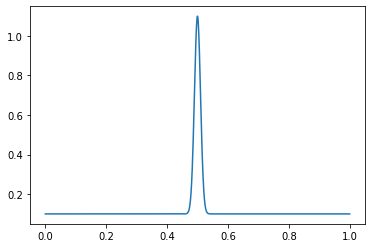

In [51]:
plt.plot(xx, rho0)

In [52]:
Pg, rho, moment, e, time = solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='LAX')
u = moment/rho

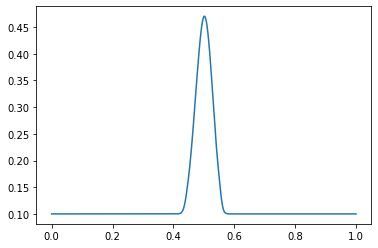

In [53]:
plt.plot(xx, rho[:, -1])

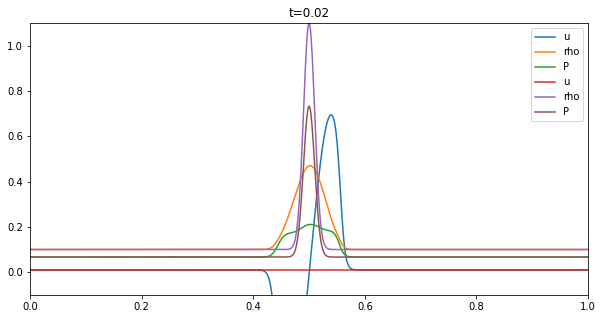

In [56]:
anim = animation(xx, time, u, rho, Pg, nt)
HTML(anim.to_jshtml())

In [ ]:
xx = nm.spatial_domain(nx, x0=0., xf=1.)
ny, nz = 1, 1
nt = 2000

PL = 1.0
PR = 0.1

u0 = np.zeros(nx)+0.1
e0 = np.zeros(nx)+0.1
e0[:nx2] = PL/(γ - 1)
e0[nx2:] = PR/(γ - 1)

rho0 = np.zeros(nx)
Pg0 = (γ - 1)*e0
rho0[:nx2] = 1.0
rho0[nx2:] = 0.125

In [ ]:
Pg, rho, moment, e, time= solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='LAX')

In [ ]:
u = moment/rho
#anim = animation(xx, time, u, rho, Pg, nt)
#HTML(anim.to_jshtml())

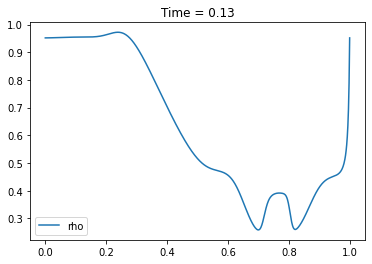

In [ ]:
value = 0.2

t_idx = np.abs(time - value).argmin()
plt.plot(xx, rho[:, t_idx], label='rho')
plt.title(f'Time = {time[t_idx]:.2f}')
plt.legend()
plt.show()

In [ ]:
x_sod, P_sod, rho_sod, u_sod, t_sod = nm.solve_sod_array(t_end=0.2, nt=100)

In [ ]:
#anim = nm.animate_sod(x_sod, P_sod, rho_sod, u_sod, t_sod)
#HTML(anim.to_jshtml())

# Implementing several dimensions

In [279]:
def init_array3D(domain, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((*domain, nt)) 
    Pg = np.zeros((*domain, nt))   
    moment = np.zeros((*domain, nt))
    rho = np.zeros((*domain, nt))
    u = np.zeros((*domain, nt))
    
    idx = (..., 0)
    
    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0
    return Pg, e, moment, rho, u
    
def solver3D(domain, xx, yy, zz, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1]):
    Pg, e, moment, rho, u = init_array3D(domain, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    
    rho_rhs = np.array(domain)
    moment_rhs = np.array(domain)
    e_rhs = np.array(domain)
    for i in range(0, nt-1):
        idx = (..., i)
        #u = moment[idx]/(rho[idx] + eps)
        u = moment/(rho + eps)
        Pg_temp = Pg#[idx]
        rho_t = rho[idx]
        moment_t = moment[idx]
        e_t = e[idx]

        cs = np.sqrt(γ * Pg_temp[idx]/(rho[idx] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u[idx] + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u[idx] - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u[idx] + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        if method == 'FTCS':
            # TODO EOS for the y and z terms. broadcasting error
            # x terms
            idx_x = (slice(None), 0, 0, i)
            rho_rhs_x = - ddx(xx, rho[idx_x] * u[idx_x])
            # TODO get NAN values here
            moment_rhs_x = -ddx(xx, moment[idx_x]*u[idx_x] + Pg_temp[idx_x])
            e_rhs_x = - ddx(xx, e[idx_x] * u[idx_x]) - Pg_temp[idx_x]*ddx(xx, u[idx_x])

            # y terms
            idx_y = (0, slice(None), 0, i)
            rho_rhs_y = - ddx(yy, rho[idx_y] * u[idx_y])
            moment_rhs_y = -ddx(yy, moment[idx_y]*u[idx_y] + Pg_temp[idx_y])
            e_rhs_y = - ddx(yy, e[idx_y] * u[idx_y]) - Pg_temp[idx_y]*ddx(yy, u[idx_y])

            # z terms
            idx_z = (0, 0, slice(None), i)
            rho_rhs_z = - ddx(zz, rho[idx_z] * u[idx_z])
            moment_rhs_z = -ddx(zz, moment[idx_z]*u[idx_z] + Pg_temp[idx_z])
            e_rhs_z = - ddx(zz, e[idx_z] * u[idx_z]) - Pg_temp[idx_z]*ddx(zz, u[idx_z])

            rho_rhs = rho_rhs_x + rho_rhs_y + rho_rhs_z
            print(rho_rhs)
            moment_rhs = moment_rhs_x + moment_rhs_y + moment_rhs_z
            e_rhs = e_rhs_x + e_rhs_y + e_rhs_z
            
            rho_temp = rho[idx] + rho_rhs*dt
            print(rho_temp)
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[idx], -1) + rho[idx] + np.roll(rho[idx], 1))/ 3.
            moment_lax = (np.roll(moment[idx], -1) + moment[idx] + np.roll(moment[idx], 1))/ 3.
            e_lax = (np.roll(e[idx], -1) + e[idx] + np.roll(e[idx], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
        # Boundary conditions
        #if bnd_limits[1] > 0:  # up and centre
        #    rho_bc = rho_temp[bnd_limits[0]:-bnd_limits[1], np.newaxis, np.newaxis, :].reshape(domain)
        #    moment_bc = moment_temp[bnd_limits[0]:-bnd_limits[1], np.newaxis, np.newaxis, :]
        #    e_bc = e_temp[bnd_limits[0]:-bnd_limits[1], np.newaxis, np.newaxis, :]
        #else:
        #    rho_bc = rho_temp[bnd_limits[0]:, np.newaxis, np.newaxis, :]
        #    moment_bc = moment_temp[bnd_limits[0]:, np.newaxis, np.newaxis, :]
        #    e_bc = e_temp[bnd_limits[0]:, np.newaxis, np.newaxis, :]


        # Variable update
        idx_next = (..., i+1)
        rho[idx_next] = rho_temp
        moment[idx_next] = moment_temp
        e[idx_next] = e_temp
        Pg_temp = (γ - 1) * e[idx_next]
        Pg[idx_next] = Pg_temp
        
        time[i+1] = time[i] + dt
        
    return Pg, rho, moment, e, time

def gauss3D(xx, yy, zz, A, mu, sigma, C):
    x_term = -.5*(xx - mu[0])**2 / sigma[0]**2 
    y_term = -.5*(yy - mu[1])**2 / sigma[1]**2 
    z_term = -.5*(zz - mu[2])**2 / sigma[2]**2
    exponent = x_term + y_term + z_term
    ans = A * np.exp(exponent) + C
    return ans


## Testing on gaussian `(nx, 1, 1)`

In [252]:
γ = 5/3
nt = 20
nx, ny, nz = 10, 10, 10
domain = (nx, ny, nz)
xx = nm.spatial_domain(nx, x0=0, xf=1)#np.linspace(0, 1, nx)
yy = np.zeros(ny)
zz = np.zeros(nz)
A = 1
#mu = [0.5, 0.5, 0.5]
#sigma = [0.1, 0.1, 0.1]
mu = 0.5
sigma = 0.1
C = 0.1

In [253]:
u0 = np.zeros(domain) + 0.1
e0 = np.zeros(domain)
e0[:, 0, 0] = gauss(xx, A, mu, sigma, C)
#e0 = gauss3D(xx[:, np.newaxis, np.newaxis], yy, zz, 1, mu, sigma, C=0.1)
#e0 = e0.reshape(domain)
Pg0 = (γ - 1)*e0 
rho0 = np.ones(domain)

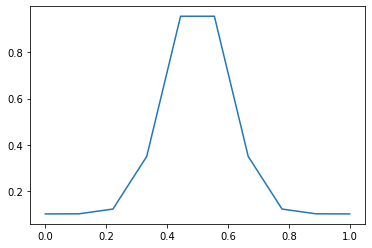

In [254]:
plt.plot(xx, e0[:, 0, 0])

In [280]:
Pg, rho, moment, e, time = solver3D(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0)

[nan nan nan nan nan nan nan nan nan nan]
[[[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan

/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py:37: RuntimeWarning: invalid value encountered in divide
  y = ((np.roll(hh, -1) - np.roll(hh, 0))
/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py:37: RuntimeWarning: divide by zero encountered in divide
  y = ((np.roll(hh, -1) - np.roll(hh, 0))


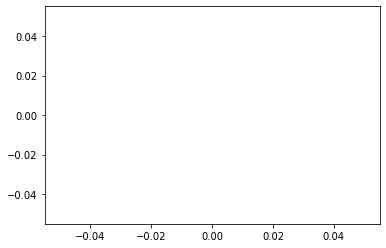

In [256]:

plt.plot(xx, Pg[:, 0, 0, 1])